In [234]:
import torch
import torch.nn as nn
from torch.optim import SGD

import numpy as np
import matplotlib.pyplot as plt

In [235]:
class NeuralNet(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(NeuralNet, self).__init__()
        self.hidden = nn.ModuleList()
        self.input_layer = nn.Linear(input_size, hidden_size)
        for k in range(num_layers-1):
            self.hidden.append(nn.Linear(hidden_size, hidden_size))
        self.output_layer = nn.Linear(hidden_size, num_classes)
    
    def forward(self, x):
        x=self.input_layer(x)
        x=x.relu()
        for layer in self.hidden:
            x=layer(x)
            x=x.relu()
        x=self.output_layer(x)
        return x
    
def ReLU_glorot_init(model):
    for name, param in model.named_parameters():
        
        if name.endswith(".bias"):
            param.data.fill_(0)
        else:
            nn.init.xavier_normal_(param)

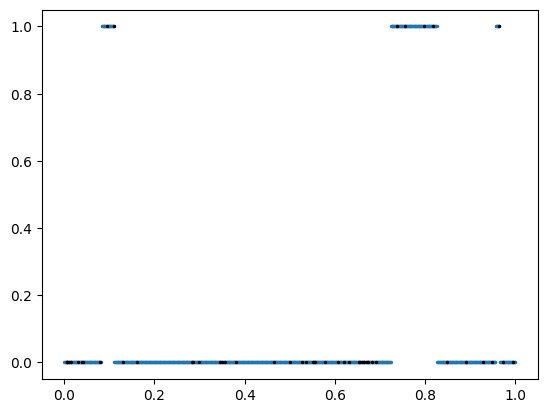

In [236]:
NUM_SAMPLES = 1000
NUM_TRAIN_SAMPLES = 50

X=np.linspace(0,1,NUM_SAMPLES)

breaks=np.sort(np.random.random(6))

encode_inputs=lambda x: 1 if (x>breaks[0] and x<breaks[1]) or (x>breaks[2] and x<breaks[3]) or (x>breaks[4] and x<breaks[5]) else 0
Y=np.array([encode_inputs(x) for x in X])

X = torch.from_numpy(X).float()
Y = torch.from_numpy(Y).float()

TRAIN_INDICES = np.random.choice(np.arange(NUM_SAMPLES),size=NUM_TRAIN_SAMPLES,replace=False)
X_TRAIN = X[TRAIN_INDICES]
Y_TRAIN = Y[TRAIN_INDICES]

plt.scatter(X,Y,s=2)
plt.scatter(X_TRAIN,Y_TRAIN,c='black',s=2)

In [237]:
INPUT_SIZE = 1
HIDDEN_SIZE = 32
NUM_LAYERS = 4
OUTPUT_SIZE = 2

BATCH_SIZE = 10
LEARNING_RATE = 0.1
NUM_EPOCHS = 1000

In [238]:
model = NeuralNet(INPUT_SIZE,HIDDEN_SIZE, NUM_LAYERS, OUTPUT_SIZE)

def next_batch(inputs, targets, batchSize):
	for i in range(0, inputs.shape[0], batchSize):
		yield (inputs[i:i + batchSize], targets[i:i + batchSize])
		
opt = SGD(model.parameters(), lr=LEARNING_RATE)
lossFunc = nn.CrossEntropyLoss()

for epoch in range(NUM_EPOCHS):
	for x,y in next_batch(X_TRAIN,Y_TRAIN,BATCH_SIZE):
		x=x.reshape((len(x),1))
		outputs = model(x)
		loss = lossFunc(outputs, y.long())
		opt.zero_grad()
		loss.backward()
		opt.step()
	print('Epoch {}: Loss {:.3f}'.format(epoch+1,loss.item()))

Epoch 1: Loss 0.500
Epoch 2: Loss 0.369
Epoch 3: Loss 0.289
Epoch 4: Loss 0.237
Epoch 5: Loss 0.206
Epoch 6: Loss 0.187
Epoch 7: Loss 0.175
Epoch 8: Loss 0.168
Epoch 9: Loss 0.164
Epoch 10: Loss 0.161
Epoch 11: Loss 0.159
Epoch 12: Loss 0.158
Epoch 13: Loss 0.157
Epoch 14: Loss 0.157
Epoch 15: Loss 0.156
Epoch 16: Loss 0.156
Epoch 17: Loss 0.155
Epoch 18: Loss 0.155
Epoch 19: Loss 0.155
Epoch 20: Loss 0.154
Epoch 21: Loss 0.154
Epoch 22: Loss 0.153
Epoch 23: Loss 0.153
Epoch 24: Loss 0.153
Epoch 25: Loss 0.153
Epoch 26: Loss 0.152
Epoch 27: Loss 0.152
Epoch 28: Loss 0.152
Epoch 29: Loss 0.151
Epoch 30: Loss 0.151
Epoch 31: Loss 0.150
Epoch 32: Loss 0.150
Epoch 33: Loss 0.150
Epoch 34: Loss 0.149
Epoch 35: Loss 0.149
Epoch 36: Loss 0.149
Epoch 37: Loss 0.148
Epoch 38: Loss 0.148
Epoch 39: Loss 0.148
Epoch 40: Loss 0.147
Epoch 41: Loss 0.147
Epoch 42: Loss 0.146
Epoch 43: Loss 0.146
Epoch 44: Loss 0.146
Epoch 45: Loss 0.146
Epoch 46: Loss 0.145
Epoch 47: Loss 0.145
Epoch 48: Loss 0.144
E

In [239]:
model_outputs=model(X.reshape(len(X),1)).max(1)[1]
classified=Y==model_outputs
c_list=[]
for ver in classified:
    if ver:
        c_list.append('green')
    else:
        c_list.append('red')

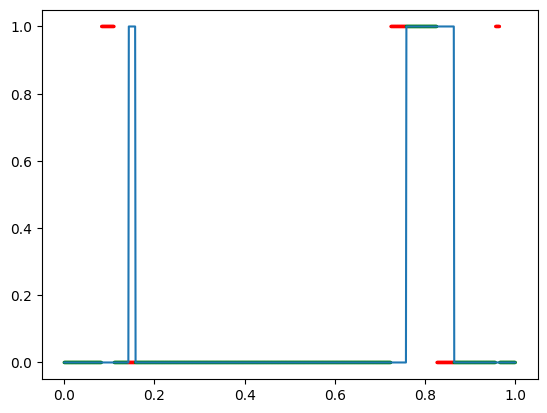

In [240]:
plt.plot(X,model_outputs.detach().numpy())
plt.scatter(X,Y,s=2,c=c_list)

In [241]:
classified_X=X[classified]
classified_Y=Y[classified]
misclassified_X=X[torch.logical_not(classified)]
misclassified_Y=Y[torch.logical_not(classified)]

p_Delta = len(classified_X)/NUM_SAMPLES

In [244]:
print(p_Delta)

0.876


In [242]:
opt = SGD(model.parameters(), lr=LEARNING_RATE)
lossFunc = nn.CrossEntropyLoss()

train_error=0
with torch.no_grad():
    for (x,y) in next_batch(X_TRAIN,Y_TRAIN,5):
        output=model(x.reshape(len(x),1))
        loss = lossFunc(output, y.long())
        train_error+=loss.item()*len(x)
    train_error=train_error/NUM_TRAIN_SAMPLES

true_error=0
with torch.no_grad():
    for (x,y) in next_batch(X,Y,5):
        output=model(x.reshape(len(x),1))
        loss = lossFunc(output, y.long())
        true_error+=loss.item()*len(x)
    true_error=true_error/NUM_SAMPLES

print('Train Error {:.3f}, True Error {:.3f}'.format(train_error,true_error))

Train Error 0.214, True Error 0.251


In [243]:
delta = 0.05

log_component = np.log((1-p_Delta+np.sqrt((1-p_Delta)**2+4*delta**(1/NUM_TRAIN_SAMPLES)*p_Delta))/(2*delta**(1/NUM_TRAIN_SAMPLES)))

bound = train_error+np.sqrt(log_component/2)

print(bound)

0.340239785188131


In [270]:
def next_batch(inputs, targets, batchSize):
    for i in range(0, inputs.shape[0], batchSize):
        yield (inputs[i:i + batchSize], targets[i:i + batchSize])

def get_bound(feature_dataset, label_dataset, feature_train, label_train, deltas, print_loss=False):
    model = NeuralNet(INPUT_SIZE,HIDDEN_SIZE, NUM_LAYERS, OUTPUT_SIZE)
            
    opt = SGD(model.parameters(), lr=LEARNING_RATE)
    lossFunc = nn.CrossEntropyLoss()

    num_samples=len(feature_dataset)
    num_train_samples=len(feature_train)

    for epoch in range(NUM_EPOCHS):
        for x,y in next_batch(feature_train,label_train,BATCH_SIZE):
            x=x.reshape((len(x),1))
            outputs = model(x)
            loss = lossFunc(outputs, y.long())
            opt.zero_grad()
            loss.backward()
            opt.step()
        if (epoch+1)%100==0 and print_loss:
            print('Epoch {}: Loss {:.3f}'.format(epoch+1,loss.item()))

    model_outputs=model(feature_dataset.reshape(len(feature_dataset),1)).max(1)[1]
    classified=label_dataset==model_outputs

    p_Delta=(sum(classified)/num_samples).numpy()

    train_error=0
    with torch.no_grad():
        for (x,y) in next_batch(feature_train,label_train,5):
            output=model(x.reshape(len(x),1))
            loss = lossFunc(output, y.long())
            train_error+=loss.item()*len(x)
        train_error=train_error/num_train_samples

    true_error=0
    with torch.no_grad():
        for (x,y) in next_batch(feature_dataset,label_dataset,5):
            output=model(x.reshape(len(x),1))
            loss = lossFunc(output, y.long())
            true_error+=loss.item()*len(x)
        true_error=true_error/num_samples
    bounds=[]
    for delta in deltas:
        log_component = np.log((1-p_Delta+np.sqrt((1-p_Delta)**2+4*delta**(1/num_train_samples)*p_Delta))/(2*delta**(1/num_train_samples)))

        bounds.append(train_error+np.sqrt(log_component/2))
    
    return train_error, true_error, bounds

In [272]:
NUM_TESTS=100
DELTAS=[0.01,0.05,0.1]
tightness=[[] for n in range(len(DELTAS))]
emp_prob=np.zeros(len(DELTAS))

for k in range(NUM_TESTS):
    tr_er, ts_er, bs = get_bound(X,Y,X_TRAIN,Y_TRAIN,DELTAS)
    for i,bound in enumerate(bs):
        if ts_er<bound:
            emp_prob[i]+=1
        tightness[i].append(bound-ts_er)
    print(k)
emp_prob=emp_prob/NUM_TESTS
print(emp_prob)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
[1.   1.   0.99]


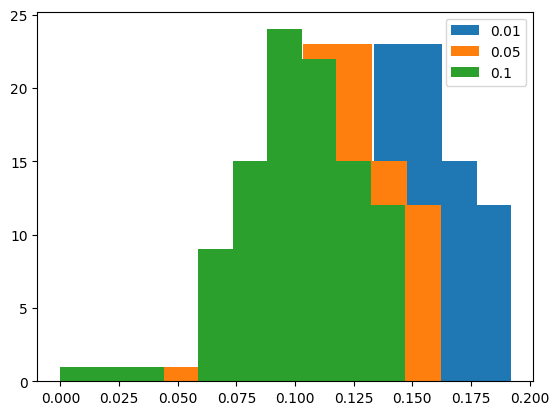

In [275]:
plt.hist(tightness[0],label='0.01')
plt.hist(tightness[1],label='0.05')
plt.hist(tightness[2],label='0.1')
plt.legend()